In [422]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Profile branoss does not have a password on file through keyring. If you are expecting this behavior (PKI or IWA authentication, entering password through run-time prompt, etc.), please ignore this message. If you would like to store your password in the branoss profile, run GIS(profile = 'branoss', password = ...). See the API doc for more details. (http://bit.ly/2CK2wG8)


In [424]:
df = pd.read_csv('files/all.csv', index_col='Unnamed: 0')

In [428]:
# Dropping street and housenumber for now, but might be intereting later use it, eg via a graph library

df = df.drop(['property.location.box', 'property.location.street',
              'property.location.latitude', 'property.location.longitude',
              'property.location.locality', 'property.location.number',
              'Address',], axis=1)

df = df.drop(columns=['flags.main','customerLogoUrl','customerName','media.pictures',
                      'flags.secondary','Price','property.title','publication.size',
                      'publication.visualisationOption','External reference',
                      'Reference number of the EPC report','Website', 'Available as of'


                      ], axis =1)


In [454]:

pdx_map = gis.map('Antwerp, ANT')
pdx_map.basemap='gray'
pdx_map

MapView(layout=Layout(height='400px', width='100%'))

In [ ]:
# Removing outliers
df = df[df['Floor :'] < 30]

# Geen openbare verkopen waar we moeten bieden of verkopen op lijfrente.
df = df[df['price.label'] == 'Price']

# Geen slaapkamers vermeld is nogal raar.

df = df[df['property.bedroomCount'] > 0]

df[['Double glazing','Armored door','Elevator','Basement','Intercom']] =\
    df[['Double glazing','Armored door','Elevator','Basement','Intercom',]]\
        .replace('Yes', 1).replace('No',0)

df[['Planning permission obtained', 'Type of building']] = df[['Planning permission obtained','Type of building']].replace('Yes', 1).replace('No',0)

df['CO² emission'] = df['CO² emission'].str.strip('kg CO2/m²').replace('Not specified',np.nan)

df['E-level (primary energy consumption)'] = df['E-level (primary energy consumption)']\
    .str.strip('kWh/m²kilowatt hour per square meters').replace('Not specified',np.nan)

df['Living area'] = df['Living area'].str.strip('m²square meters').replace('Not specified',np.nan)
df['Living room surface'] = df['Living room surface'].str.strip('m²square meters').replace('Not specified',np.nan)
df['Bedroom 1 surface'] = df['Bedroom 1 surface'].str.strip('m²square meters').replace('Not specified',np.nan)
df['Bedroom 2 surface'] = df['Bedroom 2 surface'].str.strip('m²square meters').replace('Not specified',np.nan)
df['Terrace surface'] = df['Terrace surface'].str.strip('m²square meters').replace('Not specified',np.nan)

df['Cadastral income'] = df['Cadastral income'].str.strip('€')



to_drop = ['Floor','price.shortDisplayPrice','price.accessibilityPrice',
           'price.mainDisplayPrice', 'property.location.floor','Bedrooms','bedrooms','bedroom',
           'transaction.sale.price','bathroom']
df = df.drop(to_drop, axis=1)

In [430]:
for column in df.columns:
    if df[column].isnull().sum() > 0.8*len(df):
        df = df.drop(column, axis=1)
    elif len(df[column].unique()) == 1:
        print(f'Dropping {column}, {df[column].unique()}')
        df = df.drop(column, axis=1)

Dropping isBookmarked, [0.]
Dropping price.label, ['Price']
Dropping price.language, ['en']
Dropping price.type, ['residential_sale']
Dropping property.location.country, ['Belgium']
Dropping property.location.district, ['Antwerp']
Dropping property.location.province, ['Antwerp']
Dropping property.location.region, ['Flanders']
Dropping property.location.regionCode, ['FLANDERS']
Dropping property.type, ['APARTMENT']
Dropping transaction.type, ['FOR_SALE']
Dropping Yearly theoretical total energy consumption, ['Not specified']


In [431]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2034 entries, 1 to 4175
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    2034 non-null   float64
 1   price.mainValue                       2034 non-null   float64
 2   property.bedroomCount                 2034 non-null   float64
 3   property.location.postalCode          2034 non-null   int64  
 4   property.netHabitableSurface          1897 non-null   float64
 5   property.subtype                      2034 non-null   object 
 6   Unnamed: 0.1                          2034 non-null   int64  
 7   Armored door                          638 non-null    float64
 8   Bathrooms                             1817 non-null   float64
 9   Construction year                     1324 non-null   float64
 10  Double glazing                        1401 non-null   float64
 11  E-level (primary 

In [432]:
# df['Available as of'].value_counts(dropna=False,sort=True)


In [433]:
floats = ['E-level (primary energy consumption)','Terrace surface',
          'Bedroom 2 surface','Bedroom 1 surface','Living area','Living room surface',
          'Cadastral income']

df[floats] = df[floats].apply(lambda x: x.str.replace('.','').str.replace(',','.')
                              .str.strip().replace(',','.')).astype(float)

In [434]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2034 entries, 1 to 4175
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    2034 non-null   float64
 1   price.mainValue                       2034 non-null   float64
 2   property.bedroomCount                 2034 non-null   float64
 3   property.location.postalCode          2034 non-null   int64  
 4   property.netHabitableSurface          1897 non-null   float64
 5   property.subtype                      2034 non-null   object 
 6   Unnamed: 0.1                          2034 non-null   int64  
 7   Armored door                          638 non-null    float64
 8   Bathrooms                             1817 non-null   float64
 9   Construction year                     1324 non-null   float64
 10  Double glazing                        1401 non-null   float64
 11  E-level (primary 

In [435]:
one_hots = ['property.subtype', 'Flood zone type', 'Heating type','Kitchen type',
            'Building condition', 'Type of building','As built plan','property.location.postalCode'
            ]

df = pd.get_dummies(data= df, columns=one_hots)

In [436]:
# Ordinal encoding
scale_mapper = {'A':1,
                'B':2,
                'C':3,
                'D':4,
                'E':5,
                'F':6,
                'Not specified': np.nan
                }

df['Energy class'] = df['Energy class'].replace(scale_mapper)

In [437]:
df.head().T

,1,2,4,5,9
id,8745713.000000000000000000000000000000000000000...,8745715.000000000000000000000000000000000000000...,8744282.000000000000000000000000000000000000000...,8664757.000000000000000000000000000000000000000...,8614460.000000000000000000000000000000000000000...
price.mainValue,185000.0000000000000000000000000000000000000000...,280000.0000000000000000000000000000000000000000...,184000.0000000000000000000000000000000000000000...,149000.0000000000000000000000000000000000000000...,175000.0000000000000000000000000000000000000000...
property.bedroomCount,2.000000000000000000000000000000000000000000000...,3.000000000000000000000000000000000000000000000...,1.000000000000000000000000000000000000000000000...,1.000000000000000000000000000000000000000000000...,2.000000000000000000000000000000000000000000000...
property.netHabitableSurface,84.00000000000000000000000000000000000000000000...,138.0000000000000000000000000000000000000000000...,68.00000000000000000000000000000000000000000000...,40.00000000000000000000000000000000000000000000...,105.0000000000000000000000000000000000000000000...
Unnamed: 0.1,1.000000000000000000000000000000000000000000000...,2.000000000000000000000000000000000000000000000...,4.000000000000000000000000000000000000000000000...,5.000000000000000000000000000000000000000000000...,9.000000000000000000000000000000000000000000000...
...,...,...,...,...,...
property.location.postalCode_2950,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...
property.location.postalCode_2960,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...
property.location.postalCode_2970,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...
property.location.postalCode_2980,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...,0.000000000000000000000000000000000000000000000...


In [438]:
df.to_csv('files/cleaned.csv')


In [439]:
def remove_outlier(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound  = q1 - (1.5  * iqr)
  upper_bound = q3 + (1.5 * iqr)
  out_df = df.loc[(df[col] > lower_bound) & (df[col] < upper_bound)]
  return out_df
df = remove_outlier(df,"price.mainValue")

threshold = len(df) * .75
df.dropna(thresh = threshold, axis = 1, inplace = True)

In [440]:
df = df.fillna(0)

In [441]:
df.isnull().sum(axis = 0)


id                                   0
price.mainValue                      0
property.bedroomCount                0
property.netHabitableSurface         0
Unnamed: 0.1                         0
                                    ..
property.location.postalCode_2950    0
property.location.postalCode_2960    0
property.location.postalCode_2970    0
property.location.postalCode_2980    0
property.location.postalCode_2990    0
Length: 88, dtype: int64

In [442]:
from sklearn.model_selection import train_test_split
features =  list(df.drop(columns=['price.mainValue','Unnamed: 0.1','id'],axis=1))
X = df[features]
y = df['price.mainValue']

In [443]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [444]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
dummy_median = DummyRegressor(strategy='mean')
dummy_regressor = dummy_median.fit(X_train,y_train)
dummy_predicts = dummy_regressor.predict(X_test)
print("Model Accuracy:", dummy_regressor.score(X_test,y_test)*100)
print('$',mean_absolute_error(y_test,dummy_predicts))

Model Accuracy: -0.07397157168760327
$ 70521.3498170075


In [445]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
models = [
          DecisionTreeRegressor(criterion='mse',max_depth=11,random_state=100),
          GradientBoostingRegressor(n_estimators=200,max_depth=12, verbose=2),
            RandomForestRegressor(min_samples_leaf =1, n_estimators=100,criterion='mse',max_depth=20,random_state=100,verbose=2)]
learning_mods = pd.DataFrame()
temp = {}

DecisionTreeRegressor(max_depth=11, random_state=100)
score on training 0.8785311524345804
r2 score 0.558650806507086 

GradientBoostingRegressor(max_depth=12, n_estimators=200, verbose=2)
      Iter       Train Loss   Remaining Time 
         1  6560359056.7597            2.07s
         2  5467953719.4528            2.33s
         3  4588157086.3238            2.66s
         4  3860393699.2386            2.65s
         5  3235947879.2308            2.64s
         6  2718930698.7928            2.54s
         7  2294225686.4932            2.48s
         8  1947249240.2206            2.43s
         9  1654357797.1241            2.50s
        10  1413736783.3006            2.51s
        11  1216098334.4893            2.58s
        12  1049701616.2584            2.56s
        13   917370867.1932            2.52s
        14   803913046.1280            2.56s
        15   710441660.4954            2.59s
        16   624345969.2141            2.55s
        17   551950269.9565            2.53s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


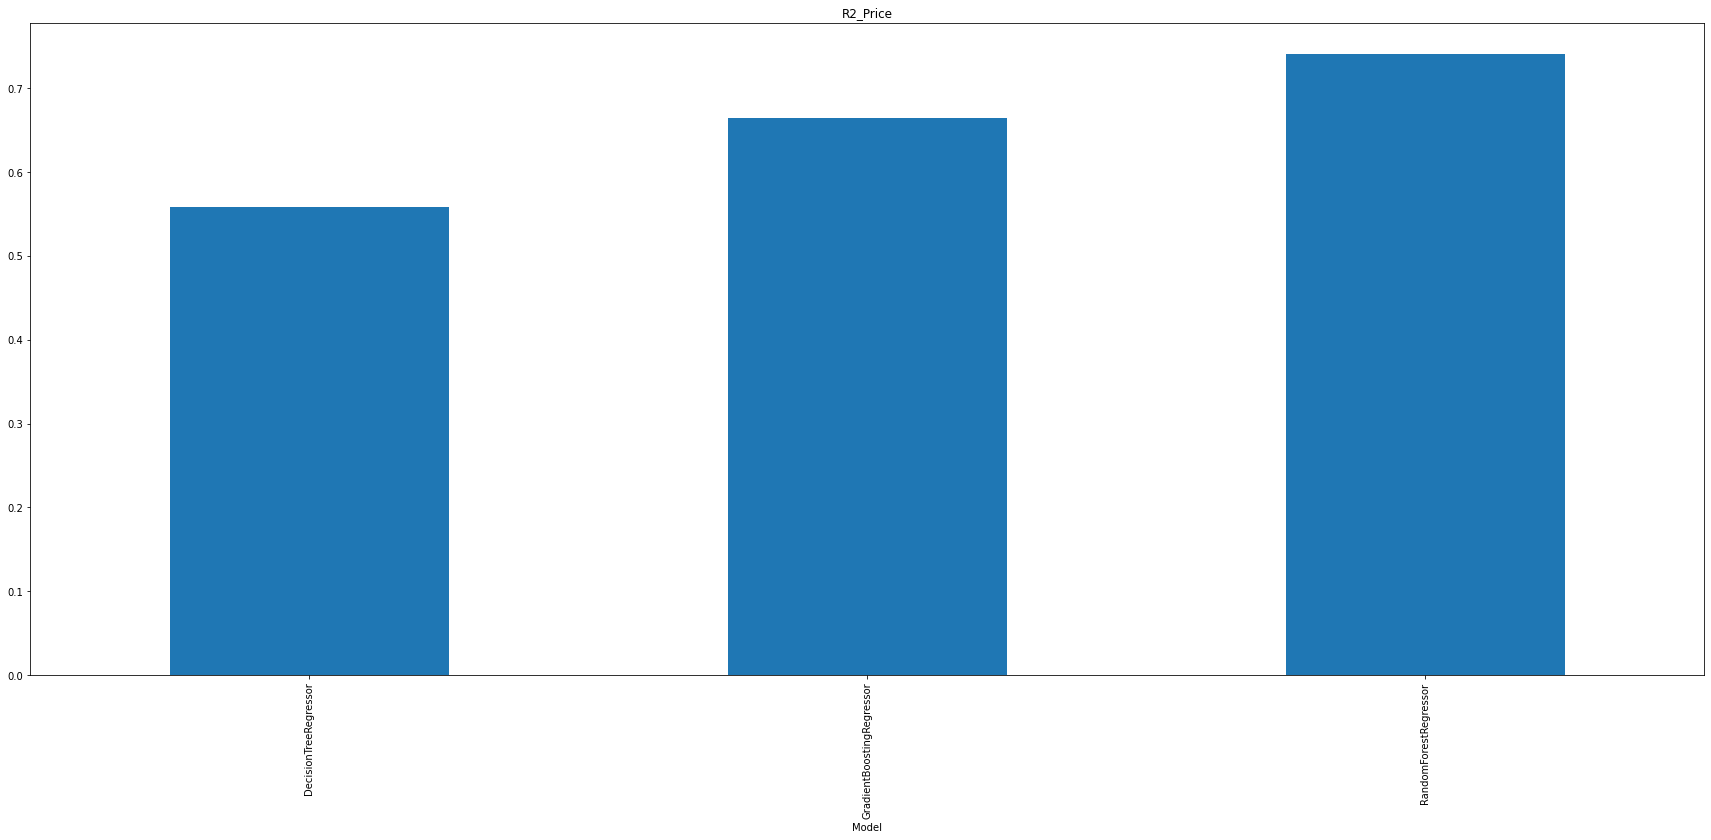

In [446]:
#run through models
for model in models:
    print(model)
    m = str(model)
    temp['Model'] = m[:m.index('(')]
    model.fit(X_train, y_train)
    temp['R2_Price'] = r2_score(y_test, model.predict(X_test))
    print('score on training',model.score(X_train, y_train))
    print('r2 score',r2_score(y_test, model.predict(X_test)),'\n')
    learning_mods = learning_mods.append([temp])
learning_mods.set_index('Model', inplace=True)

fig, axes = plt.subplots(ncols=1, figsize=(30, 12))
learning_mods.R2_Price.plot(ax=axes, kind='bar', title='R2_Price')
plt.show()

In [447]:
regressionTree_imp = model.feature_importances_
# plt.figure(figsize=(16,6))
# plt.yscale('log',nonposy='clip')
# plt.bar(range(len(regressionTree_imp)),regressionTree_imp,align='center')
# plt.xticks(range(len(regressionTree_imp)),features,rotation='vertical')
# plt.title('Feature Importance')
# plt.ylabel('Importance')
# plt.show()

In [448]:
data_tuples = list(zip(features,regressionTree_imp.tolist()))
features_importance = pd.DataFrame(data_tuples, columns=['Feature','Value'])

In [449]:
print(len(features_importance))
unimportant_features = features_importance[features_importance['Value'] < .001]
features_importance = features_importance[features_importance['Value'] > .001]
print(len(features_importance))

85
58


In [450]:
features_importance = features_importance.sort_values(by=['Value'], ascending=False)
pd.set_option('display.float_format', lambda x: '%.1000f' % x)
features_importance

,Feature,Value
1,property.netHabitableSurface,0.166010015020733425750165679346537217497825622...
3,Living area,0.162951574624261102952615942740521859377622604...
5,m²square meterslivable space,0.130193039527704779168004733946872875094413757...
42,property.location.postalCode_2000,0.102471781749267770722511272651900071650743484...
0,property.bedroomCount,0.054808452888914983847090667268275865353643894...
2,Bathrooms,0.044236856247085377946692830164465704001486301...
6,Floor :,0.037919315377762705110420426990458508953452110...
43,property.location.postalCode_2018,0.032165423857018073106051048171138972975313663...
4,Toilets,0.028038850334653257073691534628778754267841577...
34,Building condition_Good,0.018322770979149208270264637121726991608738899...


In [451]:
data_tuples = list(zip(y_test,model.predict(X_test)))
features_importance = pd.DataFrame(data_tuples, columns=['Echte Waarde','Voorspelling'])
features_importance['Voorspelling'] = features_importance['Voorspelling'].astype(float)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [452]:
features_importance.astype(int)

,Echte Waarde,Voorspelling
0,360000,339543
1,370000,323228
2,215000,208012
3,275000,328216
4,139000,181697
...,...,...
368,365000,356613
369,179000,170825
370,225000,242138
371,209000,191987
